In [139]:
import pandas as pd
import numpy as np
import string
import re
import contractions
import nltk
nltk.download('wordnet')
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to C:\Users\Vishakha
[nltk_data]     Lall\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [162]:
with open('reddit_india_submissions.csv', encoding = 'cp850') as file:
    submissions_df = pd.read_csv(file)
file.close

<function TextIOWrapper.close()>

In [163]:
submissions_df.drop([submissions_df.columns[0], 'comments'], axis='columns', inplace=True)
submissions_df['selftext'] = submissions_df['selftext'].replace(np.nan, '', regex=True)
submissions_df['title'] = submissions_df['title'].replace(np.nan, '', regex=True)
submissions_df['comments_text'] = submissions_df['comments_text'].replace(np.nan, '', regex=True)
submissions_df.head()

,author,id,flair,score,selftext,title,upvote_ratio,comments_text,comments_authors
0,IAmMohit,g1zi21,Coronavirus,165,###[Covid-19 Fundraisers & Donation Links](htt...,Coronavirus (COVID-19) Megathread - News and U...,0.96,###[Covid-19 Fundraisers & Donation Links](htt...,"[Redditor(name='IAmMohit'), Redditor(name='Sha..."
1,cool_boyy,g4d2ix,Scheduled,80,<3 \n \nLinks: ...,"[Monthly Happiness Thread] Randians, please sh...",0.90,Working from home since past one month. For so...,"[Redditor(name='cool_boyy'), Redditor(name='Mo..."
2,jatadharius,g64ani,Photography,2524,,An aerial view of Gangaikonda Cholapuram Temple,0.98,"Not the grandest temple of Tamil Nadu, but cer...","[Redditor(name='Adhi_Sekar'), Redditor(name='S..."
3,raspyduke694,g69mf0,Non-Political,193,,FIR against Arnab Goswami in Chhattisgarh for ...,0.88,"Instead of trying to make him irrelevant, we s...","[Redditor(name='athi1984'), Redditor(name='man..."
4,drunk_sithlord,g5xgab,Coronavirus,1946,,"Lockdown scenes in Kurnool, Andhra Pradesh whi...",0.98,What do you expect if you allow the market to ...,"[Redditor(name='msrd94'), Redditor(name='drunk..."


#### Number of rows after removing duplicates = 1737

In [173]:
submissions_df.shape

(1737, 36)

#### Number of unique tags = 36

In [239]:
print(len(submissions_df['flair'].unique()))
submissions_df['flair'].unique()

36


array(['Coronavirus', 'Scheduled', 'Photography', 'Non-Political',
       'Politics', 'Policy/Economy', 'Business/Finance', nan, 'Sports',
       'CAA-NRC-NPR', 'AskIndia', 'Science/Technology', 'Food',
       'Unverified', '[R]eddiquette', '/r/all', 'r/all',
       'Politics [Megathread]', 'Totally real', 'CAA-NRC', 'Zoke Tyme',
       'Official Sadness Thread', 'Demonetization',
       'Politics -- Source in comments', 'Policy & Economy',
       'Policy/Economy -2017 Article ', 'Original Comics',
       'Misleading Headline ', 'OC', 'Misleading',
       'On Internet Shutdowns', 'Lifehacks', 'AMA', 'Entertainment',
       '40 Martyrs', 'Goal Achieved!!!'], dtype=object)

In [174]:
submissions_df.describe()

,score,upvote_ratio
count,1737.000000,1737.000000
mean,1518.739206,0.902573
std,1811.175337,0.109789
min,0.000000,0.290000
25%,30.000000,0.890000
50%,1536.000000,0.940000
75%,2280.000000,0.970000
max,19707.000000,1.000000


#### Method to get wordnet's format of PoS from nltk POS 

In [107]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [108]:
submissions_df.shape

(1737, 11)

#### Preprocessing

Some pre-processing and data cleaning is required on the text based columns of the dataframe - selftext(body of submission), title and comments. Columns at each stage of the pre-processing are preserved to emphasize the motivation behind taking them up.

1. Word Contraction - Replacing commonly contracted words like "I've" to "I have" so that words are effectively tokenized
2. Tokenization - Split each individual word into a token
3. Lower case and remove punctuation - Data cleaning
4. Remove stopwords (words that do not contribute a lot to the meaning - Data Cleaning
5. Lemmatization - Add Parts of Speech (PoS) tags for wordnet format, use method to apply the conversion 
6. Remove links
7. Remove NaNs

In [170]:
punc = string.punctuation
sp = spacy.load('en')
stop_words = set(sp.Defaults.stop_words)
wnl = WordNetLemmatizer()

submissions_df['selftext'] = submissions_df['selftext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
submissions_df['selftext_not_contracted'] = submissions_df['selftext'].apply(lambda x: [contractions.fix(word) for word in str(x).split()])
submissions_df['selftext_list'] = [' '.join(map(str,l)) for l in submissions_df['selftext_not_contracted']]
submissions_df['selftext_tokenized'] = submissions_df['selftext_list'].apply(word_tokenize)
submissions_df['selftext_lower'] = submissions_df['selftext_tokenized'].apply(lambda x: [word.lower() for word in x])
submissions_df['selftext_no_punc'] = submissions_df['selftext_lower'].apply(lambda x: [word for word in x if word not in punc])
submissions_df['selftext_no_stopwords'] = submissions_df['selftext_no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
submissions_df['selftext_pos_tags'] = submissions_df['selftext_no_stopwords'].apply(nltk.tag.pos_tag)
submissions_df['selftext_wordnet_pos'] = submissions_df['selftext_pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
submissions_df['selftext_processed'] = submissions_df['selftext_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word,tag) for word, tag in x])

submissions_df['title'] = submissions_df['title'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
submissions_df['title_not_contracted'] = submissions_df['title'].apply(lambda x: [contractions.fix(word) for word in str(x).split()])
submissions_df['title_list'] = [' '.join(map(str,l)) for l in submissions_df['title_not_contracted']]
submissions_df['title_tokenized'] = submissions_df['title_list'].apply(word_tokenize)
submissions_df['title_lower'] = submissions_df['title_tokenized'].apply(lambda x: [word.lower() for word in x])
submissions_df['title_no_punc'] = submissions_df['title_lower'].apply(lambda x: [word for word in x if word not in punc])
submissions_df['title_no_stopwords'] = submissions_df['title_no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
submissions_df['title_pos_tags'] = submissions_df['title_no_stopwords'].apply(nltk.tag.pos_tag)
submissions_df['title_wordnet_pos'] = submissions_df['title_pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
submissions_df['title_processed'] = submissions_df['title_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word,tag) for word, tag in x])

submissions_df['comments_text'] = submissions_df['comments_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
submissions_df['comments_not_contracted'] = submissions_df['comments_text'].apply(lambda x: [contractions.fix(word) for word in str(x).split()])
submissions_df['comments_list'] = [' '.join(map(str,l)) for l in submissions_df['comments_not_contracted']]
submissions_df['comments_tokenized'] = submissions_df['comments_list'].apply(word_tokenize)
submissions_df['comments_lower'] = submissions_df['comments_tokenized'].apply(lambda x: [word.lower() for word in x])
submissions_df['comments_no_punc'] = submissions_df['comments_lower'].apply(lambda x: [word for word in x if word not in punc])
submissions_df['comments_no_stopwords'] = submissions_df['comments_no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
submissions_df['comments_pos_tags'] = submissions_df['comments_no_stopwords'].apply(nltk.tag.pos_tag)
submissions_df['comments_wordnet_pos'] = submissions_df['comments_pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
submissions_df['comments_processed'] = submissions_df['comments_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word,tag) for word, tag in x])


In [171]:
submissions_df.to_pickle('submissions_df_clean.pkl')

#### Example to illustrate the difference between original and pre-processed text 

In [172]:
print(submissions_df['title'][1])
print(submissions_df['title_processed'][1])

[Monthly Happiness Thread] Randians, please share a good/positive/happy news happening in your life recently ! :)
['monthly', 'happiness', 'thread', 'randians', 'share', 'good/positive/happy', 'news', 'happen', 'life', 'recently']


#### Distribution of flairs over number of posts they are tagged to

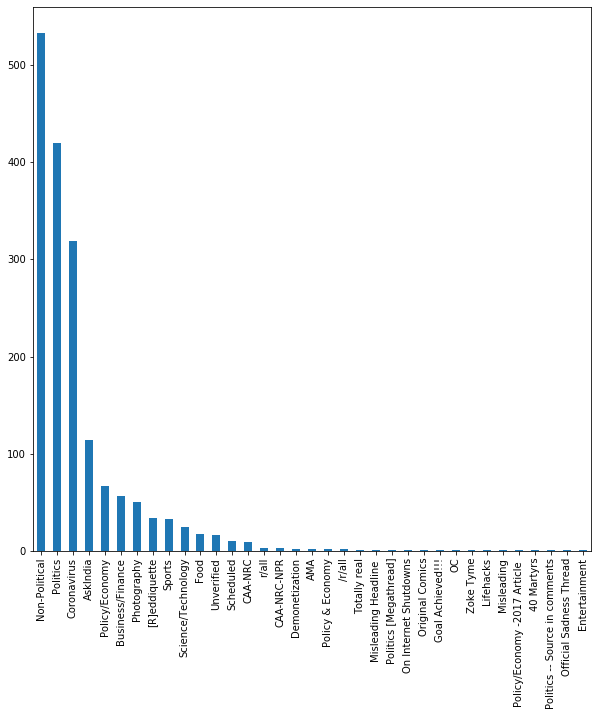

In [180]:
submissions_df['flair'].value_counts().plot.bar(figsize=(10,10))

#### Finding the top 10 flairs
- Classes for classification
- 'Other' class for all other classes(with fewer data)
- Since the submissions have been picked from top/hot posts (the trending posts during these times), the situation and events happening in the current time influence the high frequency of some flairs like 'Coronavirus' ie people are posting submissions about this flair more than other flairs

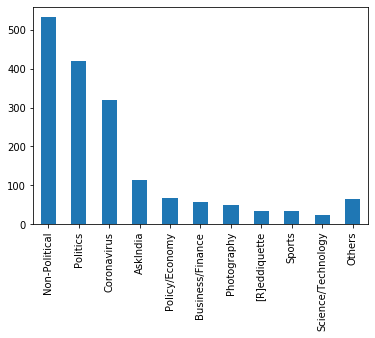

In [240]:
flair_top = submissions_df['flair'].value_counts()[:10]
flair_top.loc['Others']=submissions_df['flair'].value_counts()[11:].sum()
flair_top.plot.bar()
flair_top.to_pickle('top_flairs.pkl')

#### Explore how words are similar/related for a particular flair
- Flair Coronavirus is one of the top flairs in the submissions in the dataset
- The Wordcloud represents the word frequency of the most commonly used words in the title, top comments and selftext
- Higher weightage is given to the title (title is present in all submissions) in contrast to top comments (which are dependent on Redditors' intent and understanding), and selftext(which is not present in several submissions that are simply an image) 

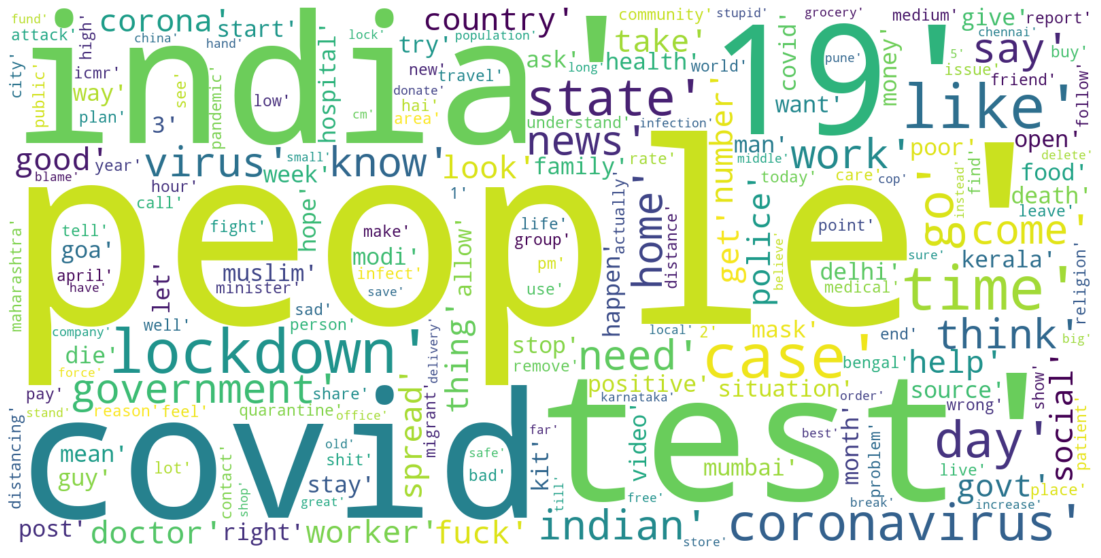

In [189]:
all_words = list()
for words in 3*submissions_df.loc[submissions_df['flair']=='Coronavirus']['title_processed']+submissions_df.loc[submissions_df['flair']=='Coronavirus']['comments_processed']+submissions_df.loc[submissions_df['flair']=='Coronavirus']['selftext_processed']:
    all_words+=words
mostcommon = FreqDist(all_words).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [232]:
author_comments_flair = submissions_df[['comments_authors','flair']]
author_comments_flair['comments_authors'] = author_comments_flair['comments_authors'].apply(lambda x: re.findall(r"'(.*?)'", x, re.DOTALL))
author_flair_df = submissions_with_author_df[['author','flair']]
author_flair_df['author']=author_flair_df['author'].apply(lambda x: [x])
pd.concat([author_flair_df,author_comments_flair.rename(columns={'comments_authors':'author'})], ignore_index=True)
author_flair_df = author_flair_df.groupby('flair').agg({'author': 'sum'})
author_flair_df['author'].apply(lambda x: set(x))
author_flair_df['count_author'] = author_flair_df['author'].apply(lambda x: len(x))
author_flair_df

C:\Users\Vishakha Lall\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vishakha Lall\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,author,count_author
flair,,
/r/all,[spikyraccoon],1
AskIndia,"[PuneriPerson, goodyougo, damnjimmie, mind-a-k...",51
Business/Finance,"[poleco1, redindian_92, datamatix, hipporama, ...",28
CAA-NRC,"[rsz619mania, Gavthi_Batman]",2
CAA-NRC-NPR,"[umarkhan13, Neglectedsince1994]",2
Coronavirus,"[IAmMohit, drunk_sithlord, DenseSpirit5, shadi...",168
Demonetization,[rohitpanshikar],1
Food,"[mitsi9577, Nightshadeinmycola, indiaisthebest...",10
Non-Political,"[91uwu, navjotjsingh, Dumma1729, MysteriousJel...",237


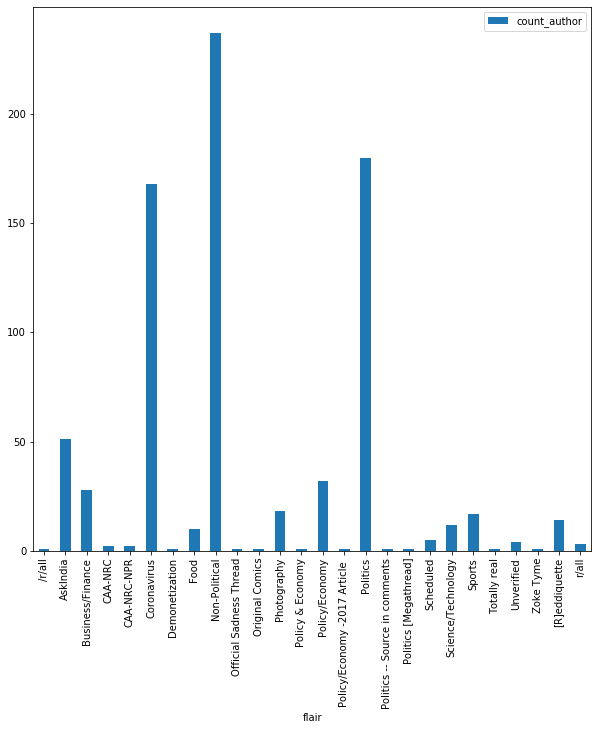

In [235]:
author_flair_df.plot.bar(figsize=(10,10))